In [210]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
import seaborn as sns



In [211]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

In [342]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
bn = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
bn_proc = make_fn(processings,bn)

#dic to map each impact func to its preprocessing function
pp_func_dic = {'Cubic excess-over-threshold':scale_qt,'Emanuel 2011':mask_qt,'Welker 2021':mask_qt}

In [343]:
#select simulation

modlist = modlist_allscen + modlist_ssp585
nmods = len(modlist)
histname = 'historical'
simname = 'stacked'
periods = ['historical','ssp585']
impf_namelist = ['CubEOT','Em2011','Sw2010']
caltype = 'AAI_EMDAT_100mn'

In [344]:
#initiate df to save results
metrics = ['aai_agg',1,10]
metnames = ["AAI_agg","1 yr impact","10 yr impact"]
iterables = [metnames,periods,impf_namelist]
col_idx1 = pd.MultiIndex.from_product(iterables,names=["metric","period","Impf"])
res_df = pd.DataFrame(columns=col_idx1,index=modlist)  


In [345]:
# import impact data
dict_res = {}
#initiate dfs
res_df = pd.DataFrame(columns=col_idx1,index=modlist)  

for modid, modname in enumerate(modlist):
    for period in periods:
        for impf in impf_namelist:
            
            impfn = make_fn(['imp',simname,period,modname,impf,caltype],bn_proc,filetype='.csv')
            
            #import impacts
            imp = Impact()
            imp = imp.from_csv(pathimp+"impact csv/aggregated/stacked"+"/"+period+"/"+impfn)
            #imp.imp_mat = imp.read_sparse_csr(impmatfn)
            for idm, metric in enumerate(metrics):
                if metric == 'aai_agg':
                    stat = imp.aai_agg
                else:  
                    stat = imp.calc_freq_curve(return_per=metric).impact
                res_df.loc[modname,(metnames[idm],period,impf)] = stat
                #reg_df.loc[modname,(reg,metnames[idm],period,impf)] = stat

res_df = res_df.astype(np.float64)


In [346]:
#by impf
idx = pd.IndexSlice
met_set = ["1 yr impact","10 yr impact"]
impf_set = impf_namelist
subset_df = res_df.loc[:,idx[met_set,:,impf_set]]
diff_df = subset_df.loc[:,idx[:,"ssp585",:]]-subset_df.loc[:,idx[:,"historical",:]].values
diff_rel_df = 100*diff_df.div(subset_df.loc[:,idx[:,"historical",:]].values)
diff_df_ss = diff_rel_df.loc[:,idx[:,:,:]].copy()
diff_df_ss.columns = diff_df_ss.columns.droplevel((1))
diff_df_ss.index.name = "model"


In [347]:
diff_df_ss

metric           1 yr impact                        10 yr impact              \
Impf                  CubEOT     Em2011      Sw2010       CubEOT      Em2011   
model                                                                          
CanESM5           -37.329569 -38.101850  -37.835811   -39.130022  -32.886777   
CNRM-CM6-1         65.616466  55.122506   46.722374   131.249622  102.114331   
CNRM-ESM2-1         4.075078   5.536939    8.978427    -1.408925   22.351724   
EC-Earth3-Veg     -26.845393 -35.327450  -25.007602   -14.780209  -18.034686   
EC-Earth3-Veg-LR  -16.895830 -34.081464  -37.708127    10.165907  -11.335821   
IPSL-CM6A-LR        6.632872  18.962659    6.750973    14.023658   22.299731   
MIROC-ES2L        -71.151651 -60.644905  -69.405180   -66.195925  -50.646631   
UKESM1-0-LL       -40.880484 -49.582355  -49.687076    -7.865911    5.829319   
MRI-ESM2-0         84.460895  45.200874   20.060377   187.231543   87.432842   
FGOALS-g3         -14.431043  -4.270447   -8.454653   -21.962363   -9.700604   
ACCESS-ESM1-5      -3.269745  10.891662   18.218685    29.249195   26.052384   
MIROC6            -25.643984 -21.448808  -37.415908    22.574994   13.547836   
MPI-ESM1-2-LR     -23.833335 -12.878701   -5.394908   -15.375717   -3.281697   
KACE-1-0-G        -64.206019 -70.604226  -69.855525   -64.332123  -77.039516   
AWI-CM-1-1-MR      -0.482345  24.466051   43.328421    67.203325   60.281736   
BCC-CSM2-MR        63.177471  52.220101   63.883421     2.303475   -4.252272   
CNRM-CM6-1-HR      33.318543  64.486503   94.092164    84.539846   84.373741   
EC-Earth3-CC       23.264332 -16.239705    1.393036    37.903012    3.696964   
HadGEM3-GC31-LL    -2.524582   2.985083    8.029504    76.370164  128.174319   
GISS-E2-1-G        93.524360  57.342481   71.073425    15.453526   52.797689   
GFDL-CM4           93.434257  99.271436  112.960498    95.697897  140.336419   
CMCC-CM2-SR5      106.609777  90.957725  110.749872   261.400088  160.556500   
CMCC-ESM2          26.658867  30.574388   45.752556    20.699891   53.399605   
HadGEM3-GC31-MM    10.387392  19.658467   27.474212    16.065684   21.820519   
NESM3              25.960161  34.250871   27.674098    31.009338   54.462321   
MPI-ESM1-2-HR       1.025080  22.374795   23.709427    47.860830   55.831977   
INM-CM4-8         -14.178586 -25.364359  -12.781971   -37.147940  -33.561586   
INM-CM5-0          45.285072  45.362374   34.448194   -16.370816  -14.834496   
ACCESS-CM2         10.756242  26.038704   16.529260    34.048685  151.501918   

metric                        
Impf                  Sw2010  
model                         
CanESM5           -15.905622  
CNRM-CM6-1         30.522573  
CNRM-ESM2-1        31.704946  
EC-Earth3-Veg     -33.384174  
EC-Earth3-Veg-LR  -11.452147  
IPSL-CM6A-LR       -3.252919  
MIROC-ES2L        -68.072362  
UKESM1-0-LL        10.865778  
MRI-ESM2-0         75.009825  
FGOALS-g3         -11.396572  
ACCESS-ESM1-5      40.643467  
MIROC6              0.626023  
MPI-ESM1-2-LR     -13.797587  
KACE-1-0-G        -79.630164  
AWI-CM-1-1-MR     247.817790  
BCC-CSM2-MR       -36.290919  
CNRM-CM6-1-HR     104.892346  
EC-Earth3-CC       65.753708  
HadGEM3-GC31-LL   108.496827  
GISS-E2-1-G       125.494772  
GFDL-CM4          334.422351  
CMCC-CM2-SR5      106.261301  
CMCC-ESM2          67.668632  
HadGEM3-GC31-MM    71.478724  
NESM3              39.557208  
MPI-ESM1-2-HR     110.091391  
INM-CM4-8         -49.457531  
INM-CM5-0         -10.329678  
ACCESS-CM2        316.219086

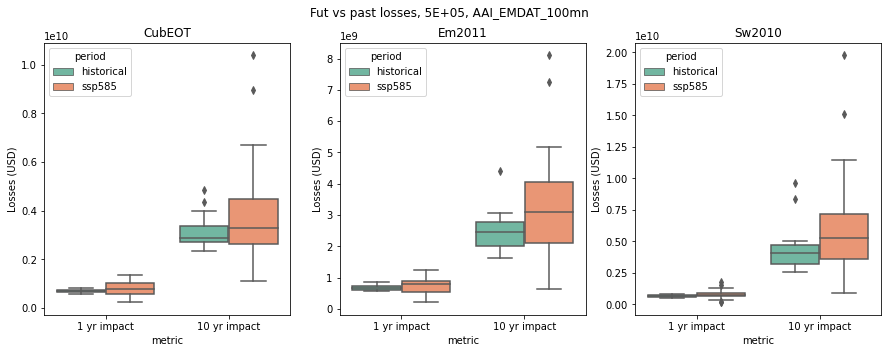

In [340]:
# fut vs past 1 plot by impf
stacked = pd.DataFrame(subset_df.stack(level=("metric","period"))).reset_index()
fig = plt.figure(figsize=(15,5))
fig.suptitle('Fut vs past losses, '+format(cut,'.0E')+', '+caltype)
axs = fig.subplots(nrows=1,ncols=3)
for i,ax in enumerate(axs):
    impf = impf_set[i]
    sns.boxplot(ax=ax,x="metric", y=impf,hue="period",data=stacked, order=["1 yr impact","10 yr impact"],palette="Set2")
    ax.set_ylabel('Losses (USD)')
    ax.set_title(impf)
    #ax.axhline(0,linewidth=2,color="r")

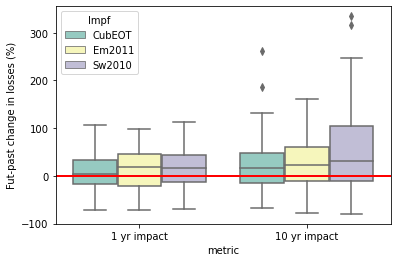

In [341]:
#percent increase
stacked = pd.DataFrame(diff_df_ss.stack(level=("metric","Impf")),columns=["Fut-past change in losses (%)"]).reset_index()
stacked_ss = stacked[stacked["metric"]=='10 yr impact']
ax = sns.boxplot(x="metric", y="Fut-past change in losses (%)",hue="Impf",data=stacked,palette="Set3")
ax.axhline(0,linewidth=2,color="r")
#fig = plt.figure(figsize=(15,5))
#fig.suptitle('Fut vs past losses, '+format(cut,'.0E')+', '+caltype)
#axs = fig.subplots(nrows=1,ncols=2)
#for i,ax in enumerate(axs):
#    metric = met_set[i]
#    sns.boxplot(ax=ax,x="metric", y=impf,hue="period",data=stacked, order=["1 yr impact","15 yr impact"],palette="Set2")
#    ax.set_ylabel('Losses (USD)')
#    ax.set_title(impf)
#    #ax.axhline(0,linewidth=2,color="r")


In [334]:
stacked_ss

Object `stacked_ss.sorted` not found.


In [314]:
stacked_ss

,model,metric,Impf,Fut-past change in losses (%)
0,CanESM5,1 yr impact,CubEOT,-37.329569
1,CanESM5,1 yr impact,Em2011,-38.101850
2,CanESM5,1 yr impact,Sw2010,-37.835811
6,CNRM-CM6-1,1 yr impact,CubEOT,65.616466
7,CNRM-CM6-1,1 yr impact,Em2011,55.122506
...,...,...,...,...
163,INM-CM5-0,1 yr impact,Em2011,45.362374
164,INM-CM5-0,1 yr impact,Sw2010,34.448194
168,ACCESS-CM2,1 yr impact,CubEOT,10.756242
169,ACCESS-CM2,1 yr impact,Em2011,26.038704


In [303]:
stacked

,model,metric,Impf,Fut-past change in losses (%)
0,CanESM5,1 yr impact,CubEOT,-37.329569
1,CanESM5,1 yr impact,Em2011,-38.101850
2,CanESM5,1 yr impact,Sw2010,-37.835811
3,CanESM5,15 yr impact,CubEOT,-16.842253
4,CanESM5,15 yr impact,Em2011,-11.819897
...,...,...,...,...
169,ACCESS-CM2,1 yr impact,Em2011,26.038704
170,ACCESS-CM2,1 yr impact,Sw2010,16.529260
171,ACCESS-CM2,15 yr impact,CubEOT,16.921103
172,ACCESS-CM2,15 yr impact,Em2011,236.621387


In [291]:
diff_df_ss

metric           1 yr impact                        15 yr impact              \
Impf                  CubEOT     Em2011      Sw2010       CubEOT      Em2011   
model                                                                          
CanESM5           -37.329569 -38.101850  -37.835811   -16.842253  -11.819897   
CNRM-CM6-1         65.616466  55.122506   46.722374   119.020025   77.274822   
CNRM-ESM2-1         4.075078   5.536939    8.978427    47.118570    0.996270   
EC-Earth3-Veg     -26.845393 -35.327450  -25.007602    14.410606  -19.425553   
EC-Earth3-Veg-LR  -16.895830 -34.081464  -37.708127    21.295334  -27.120566   
IPSL-CM6A-LR        6.632872  18.962659    6.750973    59.039582   24.083811   
MIROC-ES2L        -71.151651 -60.644905  -69.405180   -76.569475  -60.613877   
UKESM1-0-LL       -40.880484 -49.582355  -49.687076    40.604910    2.406268   
MRI-ESM2-0         84.460895  45.200874   20.060377   162.533341   65.687637   
FGOALS-g3         -14.431043  -4.270447   -8.454653    -7.791877  -15.968683   
ACCESS-ESM1-5      -3.269745  10.891662   18.218685    43.967487   26.090050   
MIROC6            -25.643984 -21.448808  -37.415908     7.253611   12.470229   
MPI-ESM1-2-LR     -23.833335 -12.878701   -5.394908   -19.123842  -10.990463   
KACE-1-0-G        -64.206019 -70.604226  -69.855525   -70.325624  -73.194893   
AWI-CM-1-1-MR      -0.482345  24.466051   43.328421   112.940709   57.516636   
BCC-CSM2-MR        63.177471  52.220101   63.883421    -9.007543  -18.782909   
CNRM-CM6-1-HR      33.318543  64.486503   94.092164    92.494645   89.730117   
EC-Earth3-CC       23.264332 -16.239705    1.393036    53.831839   29.038631   
HadGEM3-GC31-LL    -2.524582   2.985083    8.029504    89.341893  106.338536   
GISS-E2-1-G        93.524360  57.342481   71.073425     0.262624   48.799544   
GFDL-CM4           93.434257  99.271436  112.960498   246.568006  259.372169   
CMCC-CM2-SR5      106.609777  90.957725  110.749872   396.468530  344.717945   
CMCC-ESM2          26.658867  30.574388   45.752556    55.568974   34.369278   
HadGEM3-GC31-MM    10.387392  19.658467   27.474212    -6.381825   22.719622   
NESM3              25.960161  34.250871   27.674098    40.073010   47.533018   
MPI-ESM1-2-HR       1.025080  22.374795   23.709427    42.288707   61.582127   
INM-CM4-8         -14.178586 -25.364359  -12.781971   -29.307723  -34.647100   
INM-CM5-0          45.285072  45.362374   34.448194   -41.783051  -13.227543   
ACCESS-CM2         10.756242  26.038704   16.529260    16.921103  236.621387   

metric                         
Impf                   Sw2010  
model                          
CanESM5              5.746777  
CNRM-CM6-1          63.034104  
CNRM-ESM2-1         25.237576  
EC-Earth3-Veg      -22.813996  
EC-Earth3-Veg-LR   -20.405110  
IPSL-CM6A-LR        58.029098  
MIROC-ES2L         -75.729888  
UKESM1-0-LL          6.202002  
MRI-ESM2-0          82.343542  
FGOALS-g3           13.950519  
ACCESS-ESM1-5       44.066096  
MIROC6              19.587046  
MPI-ESM1-2-LR       14.010379  
KACE-1-0-G         -82.664767  
AWI-CM-1-1-MR      240.793186  
BCC-CSM2-MR        -26.061970  
CNRM-CM6-1-HR      170.914698  
EC-Earth3-CC       -49.531964  
HadGEM3-GC31-LL    129.865523  
GISS-E2-1-G         55.347640  
GFDL-CM4          1045.999588  
CMCC-CM2-SR5       367.609172  
CMCC-ESM2           61.503414  
HadGEM3-GC31-MM     31.415623  
NESM3               22.315517  
MPI-ESM1-2-HR      118.386005  
INM-CM4-8          -36.993552  
INM-CM5-0          -13.059837  
ACCESS-CM2         658.183948

In [284]:
diff_df_ss

met,1 yr impact,15 yr impact
model,,
CanESM5,-37.835811,5.746777
CNRM-CM6-1,46.722374,63.034104
CNRM-ESM2-1,8.978427,25.237576
EC-Earth3-Veg,-25.007602,-22.813996
EC-Earth3-Veg-LR,-37.708127,-20.405110
IPSL-CM6A-LR,6.750973,58.029098
MIROC-ES2L,-69.405180,-75.729888
UKESM1-0-LL,-49.687076,6.202002
MRI-ESM2-0,20.060377,82.343542


## subsetting models

In [277]:
#get loss data
idx = pd.IndexSlice
met_set = ["1 yr impact","15 yr impact"]
impf_set = impf_namelist
subset_df = res_df.loc[:,idx[met_set,:,impf_set]]
diff_df = subset_df.loc[:,idx[:,"ssp585",:]]-subset_df.loc[:,idx[:,"historical",:]].values
diff_rel_df = 100*diff_df.div(subset_df.loc[:,idx[:,"historical",:]].values)
diff_df_ss = diff_rel_df.loc[:,idx[:,:,"Sw2010"]].copy()
diff_df_ss.columns = diff_df_ss.columns.droplevel((1,2))
diff_df_ss.index.name = "model"
diff_df_ss.columns.name = "met"


In [278]:
#load indices
ind_fn = "std_an_"+"remote_indices_ZS17_sp_avg_allmods_historical_ssp585.csv"
ind_df = pd.read_csv(pathcirc+ind_fn,header=[0],index_col=[0])

In [279]:
indices = ind_df.columns.tolist()[1:]

In [280]:
#select models according to polar amplification
threshold = 0.25
polmods_pos = ind_df.where(ind_df["pol"]>threshold).dropna(how="all").index.tolist()
polmods_neg = ind_df.where(ind_df["pol"]<-threshold).dropna(how="all").index.tolist()

tropmods_pos = ind_df.where(ind_df["trop"]>threshold).dropna(how="all").index.tolist()
tropmods_neg = ind_df.where(ind_df["trop"]<-threshold).dropna(how="all").index.tolist()

stratmods_pos = ind_df.where(ind_df["strat"]>threshold).dropna(how="all").index.tolist()
stratmods_neg = ind_df.where(ind_df["strat"]<-threshold).dropna(how="all").index.tolist()

print("Pol: pos: "+str(len(polmods_pos))+", neg: "+str(len(polmods_neg)))
print("Trop: pos: "+str(len(tropmods_pos))+", neg: "+str(len(tropmods_neg)))
print("Strat: pos: "+str(len(stratmods_pos))+", neg: "+str(len(stratmods_neg)))

Pol: pos: 11, neg: 9
Trop: pos: 12, neg: 13
Strat: pos: 11, neg: 11


In [281]:
stratmods_neg

['ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-g3',
 'UKESM1-0-LL']

In [282]:
metid = diff_df_ss.columns
threshold = 0.25
df_list = []
for indice in indices:
    posmods = ind_df.where(ind_df[indice]>threshold).dropna(how="all").index.tolist()
    negmods = ind_df.where(ind_df[indice]<-threshold).dropna(how="all").index.tolist()
    cirscen = [indice+"+",indice+"-"]
    col_idx= pd.MultiIndex.from_product([cirscen,metid],names=["scen","region"])
    diff_df_neg = diff_df_ss.reindex(negmods)
    diff_df_neg = diff_df_neg.assign(scen=cirscen[1]).set_index('scen', append=True)
    df_list.append(diff_df_neg)
    diff_df_pos = diff_df_ss.reindex(posmods)
    diff_df_pos = diff_df_pos.assign(scen=cirscen[0]).set_index('scen', append=True)
    df_list.append(diff_df_pos)
    
diff_df_scen = pd.concat(df_list,axis=0,levels=0)    

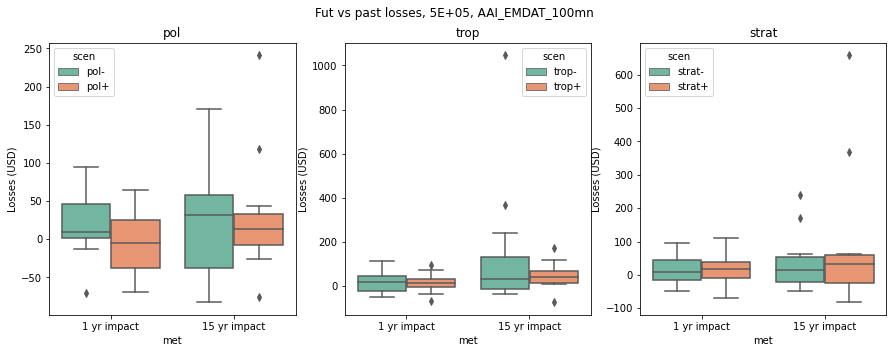

In [283]:
# fut vs past 1 plot by impf
stacked = pd.DataFrame(diff_df_scen.stack(level="met"),columns=["Fut-past change in losses (%)"]).reset_index()
fig = plt.figure(figsize=(15,5))
fig.suptitle('Fut vs past losses, '+format(cut,'.0E')+', '+caltype)
axs = fig.subplots(nrows=1,ncols=3)
for i,ax in enumerate(axs):
    indice = indices[i]
    
    stacked_ss = stacked[(stacked['scen'] == indice+'+') | (stacked['scen'] == indice+'-')]
    sns.boxplot(ax=ax,x="met", y="Fut-past change in losses (%)", hue="scen",data=stacked_ss, palette="Set2")
    ax.set_ylabel('Losses (USD)')
    ax.set_title(indice)
    #ax.axhline(0,linewidth=2,color="r")


## Fut vs past 

## Fut-past absolute differences

In [33]:
idx = pd.IndexSlice
diff_df = diff_df = res_df.loc[:,idx[:,"ssp585"]]-res_df.loc[:,idx[:,"historical"]].values

## Fut-past relative differences

In [35]:
idx = pd.IndexSlice
diff_rel_df = diff_df.div(res_df.loc[:,idx[:,"historical"]].values)

In [36]:
diff_rel_df

metric             AAI_agg                     10 yr impact            \
period              ssp585                           ssp585             
Impf                CubEOT    Em2011    Sw2010       CubEOT    Em2011   
CanESM5          -0.493902 -0.478926 -0.394226    -0.391300 -0.328868   
CNRM-CM6-1        0.685408  0.509816  0.564212     1.312496  1.021143   
CNRM-ESM2-1      -0.090816 -0.048003  0.146479    -0.014089  0.223517   
EC-Earth3-Veg    -0.167258 -0.324269 -0.319335    -0.133865 -0.105477   
EC-Earth3-Veg-LR -0.162903 -0.346420 -0.363854     0.101659 -0.113358   
IPSL-CM6A-LR      0.217126  0.317081  0.345621     0.140237  0.222997   
MIROC-ES2L       -0.750737 -0.669564 -0.757336    -0.661959 -0.506466   
UKESM1-0-LL      -0.461395 -0.508011 -0.367439    -0.078659  0.058293   
MRI-ESM2-0        1.011829  0.578935  0.293089     1.872315  0.874328   
FGOALS-g3        -0.190830 -0.179740 -0.145765    -0.219624 -0.097006   
ACCESS-ESM1-5    -0.021457  0.032816  0.081149     0.292492  0.260524   
MIROC6           -0.230970 -0.326869 -0.348116     0.225750  0.138623   
MPI-ESM1-2-LR    -0.200934 -0.139443 -0.102154    -0.153757 -0.032817   
KACE-1-0-G       -0.676755 -0.706367 -0.737938    -0.680243 -0.773970   
AWI-CM-1-1-MR     0.091658  0.143287  0.483119     0.672033  0.602817   
BCC-CSM2-MR       0.576964  0.398073  0.306880     0.023035 -0.042523   
CNRM-CM6-1-HR     0.444157  0.433325  1.349327     0.845398  0.843737   
EC-Earth3-CC      0.226487 -0.081328  0.023954     0.595827  0.036970   
HadGEM3-GC31-LL   0.047673  0.025184  0.313988     0.820086  1.336731   
GISS-E2-1-G       0.567420  0.417412  0.751198     0.154535  0.527977   
GFDL-CM4          0.969592  0.771507  2.092431     0.956979  1.403364   
CMCC-CM2-SR5      1.133752  0.951217  1.527205     2.614001  1.605565   
CMCC-ESM2         0.374674  0.338710  0.518325     0.206999  0.533996   
HadGEM3-GC31-MM   0.074839  0.124230  0.287262     0.160657  0.218205   
NESM3             0.582084  0.532608  0.616458     0.310093  0.544623   
MPI-ESM1-2-HR     0.136016  0.137720  0.594221     0.478608  0.558320   
INM-CM4-8        -0.226774 -0.117106 -0.126739    -0.371479 -0.335616   
INM-CM5-0         0.171909  0.395689  0.304729    -0.163708 -0.148345   
ACCESS-CM2        0.067951  0.347505  1.105077     0.340487  1.515019   

metric                      
period                      
Impf                Sw2010  
CanESM5          -0.159056  
CNRM-CM6-1        0.305226  
CNRM-ESM2-1       0.317049  
EC-Earth3-Veg    -0.299595  
EC-Earth3-Veg-LR -0.114521  
IPSL-CM6A-LR     -0.032529  
MIROC-ES2L       -0.680724  
UKESM1-0-LL       0.108658  
MRI-ESM2-0        0.875409  
FGOALS-g3        -0.113966  
ACCESS-ESM1-5     0.406435  
MIROC6            0.036266  
MPI-ESM1-2-LR    -0.137976  
KACE-1-0-G       -0.802820  
AWI-CM-1-1-MR     2.478178  
BCC-CSM2-MR      -0.362909  
CNRM-CM6-1-HR     1.048923  
EC-Earth3-CC      0.657537  
HadGEM3-GC31-LL   1.084968  
GISS-E2-1-G       1.254948  
GFDL-CM4          3.344224  
CMCC-CM2-SR5      1.062613  
CMCC-ESM2         0.676686  
HadGEM3-GC31-MM   0.714787  
NESM3             0.395572  
MPI-ESM1-2-HR     1.100914  
INM-CM4-8        -0.494575  
INM-CM5-0        -0.103297  
ACCESS-CM2        3.162191